# Model training

## Cross-sectional data

In [34]:
import numpy as np
import pandas as pd
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.rocket import MiniRocket, MiniRocketMultivariate
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.datasets import load_from_arff_to_dataframe
from sktime.classification.interval_based import (
    CanonicalIntervalForest,
    DrCIF,
    RandomIntervalSpectralEnsemble,
    SupervisedTimeSeriesForest,
    TimeSeriesForestClassifier,
)
from sktime.classification.kernel_based import Arsenal
from sktime.datatypes._panel._convert import from_multi_index_to_3d_numpy
from sktime.datasets import load_from_tsfile
from tsfresh.utilities.dataframe_functions import roll_time_series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.datasets import make_multilabel_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score
from mcfly.find_architecture import find_best_architecture
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

SEED=42

%matplotlib inline

In [ ]:
df = pd.read_csv("../data/odb-2-master-thesis/exp1_14drivers_14cars_dailyRoutes_interpolated.csv")
df.head()

In [ ]:
df.shape

In [ ]:
selected_columns = df.columns.difference(["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP"])
df = df[selected_columns]

TARGET = "TROUBLE_CODES_BINARY"

X = df.drop([TARGET], axis=1)
y = df[TARGET]

X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
Counter(y)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

index_train = X_train.index
index_test = X_test.index

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, index=index_train, columns=X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, index=index_test, columns=X.columns)

### Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=SEED)
log_reg.fit(X_train, y_train)

y_pred = lin_svc.predict(X_test)

print("Classification Report for the LinearSVC model \n")
print(classification_report(y_test, y_pred))

### Linear Support Vector Classifier

In [ ]:
lin_svc = LinearSVC(random_state=SEED)
lin_svc.fit(X_train, y_train)

y_pred = lin_svc.predict(X_test)

print("Classification Report for the LinearSVC model \n")
print(classification_report(y_test, y_pred))

### Random Forest Classifier

In [ ]:
# Model training
random_forest = RandomForestClassifier(random_state=SEED)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

print("Classification Report for the RandomForestClassifier model \n")
print(classification_report(y_test, y_pred))

## Time Series Classification on (3D) Panel Data

In [2]:
features_all = pd.read_parquet("../data/odb-2-window-89/features-all-windowsize89.parquet.gzip")
target_all = pd.read_parquet("../data/odb-2-window-89/target-binary-all-windowsize89.parquet.gzip")

In [3]:
features_all = features_all.set_index(["INSTANCES", "TIMEPOINTS"])
features_all.head()

AIR_INTAKE_TEMP  ENGINE_COOLANT_TEMP  ENGINE_LOAD  \
INSTANCES TIMEPOINTS                                                      
0         0                      59.0                 80.0        0.333   
          1                      59.0                 80.0        0.325   
          2                      59.0                 80.0        0.329   
          3                      60.0                 80.0        0.325   
          4                      60.0                 80.0        0.329   

                      ENGINE_RPM  SHORT TERM FUEL TRIM BANK 1  SPEED  \
INSTANCES TIMEPOINTS                                                   
0         0               1009.0                          0.0    0.0   
          1               1003.0                          0.0    0.0   
          2                995.0                          0.0    0.0   
          3               1004.0                          0.0    0.0   
          4               1005.0                          0.0    0.0   

                      THROTTLE_POS  TIMING_ADVANCE  
INSTANCES TIMEPOINTS                                
0         0                  0.251           0.569  
          1                  0.251           0.565  
          2                  0.251           0.573  
          3                  0.251           0.565  
          4                  0.251           0.569

In [4]:
# Create indices
index_train, index_test = train_test_split(features_all.index.levels[0], 
                                           test_size=0.20, 
                                           random_state=42)

In [5]:
# Split train and test
X_train = features_all.loc[index_train]
X_train = from_multi_index_to_3d_numpy(X_train)

y_train = target_all.loc[index_train]
y_train = y_train.values.flatten()

X_test = features_all.loc[index_test]
X_test = from_multi_index_to_3d_numpy(X_test)

y_test = target_all.loc[index_test]
y_test = y_test.values.flatten()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37003, 8, 89), (9251, 8, 89), (37003,), (9251,))

### MiniRocket transformation for the ODB-II DTC dataset + RidgeClassifierCV

In [6]:
%%time

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(X_train)

X_train_transform = minirocket_multi.transform(X_train)

CPU times: user 1min 16s, sys: 717 ms, total: 1min 16s
Wall time: 1min 16s


In [ ]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge.fit(X_train_transform, y_train)

MemoryError: Unable to allocate 2.76 GiB for an array with shape (37003, 9996) and data type float64

### MiniRocket transformation for the ODB-II DTC dataset + LogisticRegression

In [ ]:
%%time

log_reg = LogisticRegression(random_state=SEED)
log_reg.fit(X_train_transform, y_train)

MemoryError: Unable to allocate 2.76 GiB for an array with shape (37003, 9996) and data type float64

### MiniRocket transformation for the ODB-II DTC dataset + LinearDiscriminantAnalysis

In [9]:
X_train_transform.describe()

,0,1,2,3,4,5,6,7,8,9,...,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995
count,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,...,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000
mean,0.337251,0.732872,0.203443,0.632689,0.771703,0.309111,0.700150,0.123272,0.580193,0.736650,...,0.669026,0.035240,0.244494,0.930114,0.229568,0.570288,0.851488,0.100397,0.995622,0.008432
std,0.178903,0.146579,0.114650,0.196691,0.129835,0.164021,0.162045,0.077412,0.221398,0.144890,...,0.059347,0.184389,0.429792,0.254959,0.095995,0.059311,0.113564,0.300533,0.066023,0.091438
min,0.033708,0.426966,0.022472,0.044944,0.483146,0.033708,0.404494,0.000000,0.033708,0.426966,...,0.370787,0.000000,0.000000,0.000000,0.000000,0.325843,0.483146,0.000000,0.000000,0.000000
25%,0.044944,0.617977,0.044944,0.494382,0.662921,0.044944,0.573034,0.044944,0.471910,0.617977,...,0.629214,0.000000,0.000000,1.000000,0.134831,0.516854,0.775281,0.000000,1.000000,0.000000
50%,0.426966,0.685393,0.224719,0.539326,0.741573,0.382022,0.640449,0.112360,0.505618,0.685393,...,0.629214,0.000000,0.000000,1.000000,0.224719,0.573034,0.853933,0.000000,1.000000,0.000000
75%,0.460674,0.955056,0.292135,0.955056,0.955056,0.426966,0.955056,0.179775,0.584270,0.955056,...,0.752809,0.000000,0.000000,1.000000,0.292135,0.629214,0.955056,0.000000,1.000000,0.000000
max,0.764045,0.977528,0.685393,0.977528,0.988764,0.752809,0.977528,0.449438,0.955056,0.977528,...,0.876405,1.000000,1.000000,1.000000,0.505618,0.797753,1.000000,1.000000,1.000000,1.000000


In [12]:
%%time 

lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
lda.fit(X_train_transform, y_train)

CPU times: user 1h 7min 13s, sys: 13min 48s, total: 1h 21min 2s
Wall time: 12min 19s


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

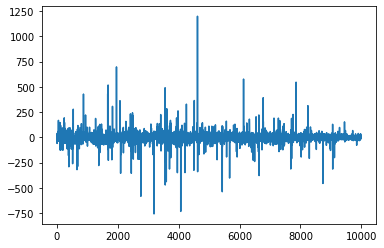

In [22]:
plt.plot(X_train_transform.columns, lda.coef_[0])
plt.show()

# pd.DataFrame(lda.coef_[0]).describe()


In [23]:
%%time 

X_test_transform = minirocket_multi.transform(X_test)

CPU times: user 18 s, sys: 117 ms, total: 18.1 s
Wall time: 18.1 s


In [25]:
%%time 

y_pred = lda.predict(X_test_transform)

CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 129 ms


In [37]:
%%time
print("Classification Report for the LinearDiscriminantAnalysis model \n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report for the LinearDiscriminantAnalysis model 

              precision    recall  f1-score   support

           0     0.9959    0.9958    0.9959      6886
           1     0.9877    0.9882    0.9880      2365

    accuracy                         0.9938      9251
   macro avg     0.9918    0.9920    0.9919      9251
weighted avg     0.9938    0.9938    0.9938      9251

CPU times: user 16 ms, sys: 1.21 ms, total: 17.2 ms
Wall time: 14.8 ms


In [36]:
print("F1 binary:", f1_score(y_test, y_pred))
print("F1 micro:", f1_score(y_test, y_pred, average="micro"))
print("F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred, average="weighted"))

F1 binary: 0.9879518072289156
F1 micro: 0.9938385039455194
F1 macro: 0.9919063371341732
F1 weighted: 0.9938389314160527


## MiniRocket transformation for the ODB-II DTC dataset + SVM

### Supervised Time Series Forest Classifier

In [ ]:
%%time 

# sts_forest = SupervisedTimeSeriesForest(n_estimators=10)
# sts_forest.fit(X_train, y_train)

ValueError: Data seen by SupervisedTimeSeriesForest instance has multivariate series, but this SupervisedTimeSeriesForest instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.

In [ ]:
# y_pred = clf.predict(X_test)

# print("Classification Report for the SupervisedTimeSeriesForest model \n")
# print(classification_report(y_test.values.flatten(), y_pred.values.flatten()))

### Mini Rocket Multivariate Transformer + Ridge Classifier

In [ ]:
%%time

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(X_train)

X_train_transform = minirocket_multi.transform(X_train)

In [ ]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge.fit(X_train_transform, y_train)

In [ ]:
X_test_transform = minirocket_multi.transform(X_test)
y_pred = ridge.predict(X_test_transform)

print("Classification Report for the RidgeClassifierCV model \n")
print(classification_report(y_test, y_pred))

### Canonical Interval Forest (CIF) Classifier

In [ ]:
%%time

cif = CanonicalIntervalForest(n_estimators=50, att_subsample_size=8, random_state=47)
cif.fit(X_train, y_train)

In [ ]:
%%time 

y_pred = cif.predict(X_test)

print("Classification Report for the Canonical Interval Forest model \n")
print(classification_report(y_test, y_pred))

### Mcfly AutoML

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
X_train = np.swapaxes(X_train, 1, 2)
X_val = np.swapaxes(X_val, 1, 2)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train)

In [ ]:
y_train

In [ ]:
%%time

best_model, best_params, best_model_type, knn_acc = \
            find_best_architecture(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val, 
                number_of_models=10,
                nr_epochs=20,
                # subset_size=5000,
            )

```
Training model 9 ResNet
Epoch 1/20
5/5 [==============================] - 20s 4s/step - loss: 0.0000e+00 - accuracy: 0.2900 - val_loss: 0.0000e+00 - val_accuracy: 0.2531
Epoch 2/20
5/5 [==============================] - 16s 4s/step - loss: 0.0000e+00 - accuracy: 0.2900 - val_loss: 0.0000e+00 - val_accuracy: 0.2531
Epoch 3/20
5/5 [==============================] - 15s 4s/step - loss: 0.0000e+00 - accuracy: 0.2900 - val_loss: 0.0000e+00 - val_accuracy: 0.2531
Epoch 3: early stopping
Best model: model  0
Model type:  InceptionTime
Hyperparameters:  {'learning_rate': 0.00987769396837994, 'regularization_rate': 0.0009260936235962637, 'network_depth': 6, 'filters_number': 79, 'max_kernel_size': 71}
accuracy on validation set:  0.25307390093803406
Accuracy of kNN on validation set 0.7289555465477638
CPU times: user 1h 55min 49s, sys: 28min 50s, total: 2h 24min 40s
Wall time: 30min 29s
```

In [ ]:
history = best_model.fit(
    X_train, 
    y_train,
    epochs=3, 
    validation_data=(X_val, y_val)
)

## Car Dataset

### MiniRocket Transformer + RidgeClassifierCV

In [2]:
X_train, y_train =  load_from_tsfile("/mnt/f/Documents/Car_TRAIN.ts")
X_test, y_test =  load_from_tsfile("/mnt/f/Documents/Car_TEST.ts")

display(X_train.head())
display(y_train[:5])

,dim_0
0,0 1.654107 1 1.621582 2 1.58921...
1,0 1.750569 1 1.710457 2 1.67046...
2,0 1.551691 1 1.517339 2 1.48199...
3,0 1.495626 1 1.457534 2 1.43109...
4,0 1.713808 1 1.675160 2 1.65091...


array(['1', '4', '2', '1', '2'], dtype='<U1')

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 1), (60, 1), (60,), (60,))

In [4]:
%%time

minirocket = MiniRocket()
minirocket.fit(X_train)

X_train_transform = minirocket.transform(X_train)

CPU times: user 2.55 s, sys: 32 µs, total: 2.55 s
Wall time: 2.54 s


In [5]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge = ridge.fit(X_train_transform, y_train)

CPU times: user 795 ms, sys: 740 ms, total: 1.53 s
Wall time: 422 ms


In [6]:
X_test_transform = minirocket.transform(X_test)
y_pred = ridge.predict(X_test_transform)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       0.85      0.89      0.87        19
           4       0.83      0.77      0.80        13

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



## Epilepsy Dataset

### MiniRocketMultivariate + RidgeClassifierCV

In [159]:
X_train, y_train =  load_from_tsfile("/mnt/f/Documents/Epilepsy_TRAIN.ts")
X_test, y_test =  load_from_tsfile("/mnt/f/Documents/Epilepsy_TEST.ts")

display(X_train.head())
display(y_train[:5])

,dim_0,dim_1,dim_2
0,0 0.35 1 0.40 2 0.44 3 0.4...,0 0.22 1 0.01 2 -0.71 3 -0.3...,0 0.55 1 0.51 2 0.52 3 0.4...
1,0 -0.91 1 -0.92 2 -0.95 3 -0.9...,0 -0.05 1 -0.02 2 0.01 3 0.0...,0 0.06 1 -1.57 2 -0.99 3 0.2...
2,0 0.32 1 0.71 2 0.70 3 0.7...,0 1.00 1 -1.33 2 -1.44 3 -0.1...,0 0.37 1 0.37 2 0.37 3 0.3...
3,0 -0.68 1 -0.36 2 -0.13 3 -0.3...,0 -1.69 1 -0.58 2 1.05 3 -0.1...,0 0.31 1 0.31 2 0.32 3 0.0...
4,0 0.34 1 0.53 2 0.58 3 0.6...,0 -0.89 1 1.17 2 1.00 3 -1.8...,0 0.45 1 -0.05 2 -0.17 3 -0.4...


array(['EPILEPSY', 'EPILEPSY', 'EPILEPSY', 'EPILEPSY', 'EPILEPSY'],
      dtype='<U8')

In [160]:
print("X_train.shape (num_sample, num_features, num_timesteps):", X_train.shape + X_train.iloc[0,0].shape)
print("X_test.shape (num_samples, num_features, num_timesteps):", X_test.shape + X_test.iloc[0,0].shape)
print("")
print("y_train.shape (num_sample,):", y_train.shape)
print("y_test.shape (num_sample,):", y_test.shape)

X_train.shape (num_sample, num_features, num_timesteps): (137, 3, 206)
X_test.shape (num_samples, num_features, num_timesteps): (138, 3, 206)

y_train.shape (num_sample,): (137,)
y_test.shape (num_sample,): (138,)


In [11]:
%%time

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(X_train)

X_train_transform = minirocket_multi.transform(X_train)

CPU times: user 5.14 s, sys: 0 ns, total: 5.14 s
Wall time: 5.13 s


In [14]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge.fit(X_train_transform, y_train)

CPU times: user 1.13 s, sys: 860 ms, total: 1.99 s
Wall time: 350 ms


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [15]:
X_test_transform = minirocket_multi.transform(X_test)
y_pred = ridge.predict(X_test_transform)

print("Classification Report for the RidgeClassifierCV model \n")
print(classification_report(y_test, y_pred))

Classification Report for the RidgeClassifierCV model 

              precision    recall  f1-score   support

    EPILEPSY       1.00      1.00      1.00        34
     RUNNING       1.00      1.00      1.00        37
      SAWING       1.00      1.00      1.00        30
     WALKING       1.00      1.00      1.00        37

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



In [ ]:
%%time 

stsf = SupervisedTimeSeriesForest(n_estimators=5)
stsf.fit(X_train, y_train)

ValueError: Data seen by SupervisedTimeSeriesForest instance has multivariate series, but this SupervisedTimeSeriesForest instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.


## FordA Dataset

In [147]:
%%time 

X_train, y_train =  load_from_tsfile("/mnt/f/Downloads/FordA/FordA_TRAIN.ts")
# y_train = np.where(y_train == "1" , 1, 0)

X_test, y_test =  load_from_tsfile("/mnt/f/Downloads/FordA/FordA_TEST.ts")
# y_test = np.where(y_test == "1" , 1, 0)

display(X_train.head())
display(y_train[:5])

,dim_0
0,0 -0.797172 1 -0.664392 2 -0.37301...
1,0 0.804855 1 0.634629 2 0.37347...
2,0 0.727985 1 0.111284 2 -0.49912...
3,0 -0.234439 1 -0.502157 2 -0.73248...
4,0 -0.171328 1 -0.062285 2 0.23582...


array(['-1', '1', '-1', '-1', '-1'], dtype='<U2')

CPU times: user 6.13 s, sys: 162 ms, total: 6.29 s
Wall time: 8.09 s


In [148]:
print("X_train.shape (num_sample, num_features, num_timesteps):", X_train.shape + X_train.iloc[0,0].shape)
print("X_test.shape (num_samples, num_features, num_timesteps):", X_test.shape + X_test.iloc[0,0].shape)
print("")
print("y_train.shape (num_sample,):", y_train.shape)
print("y_test.shape (num_sample,):", y_test.shape)

X_train.shape (num_sample, num_features, num_timesteps): (3601, 1, 500)
X_test.shape (num_samples, num_features, num_timesteps): (1320, 1, 500)

y_train.shape (num_sample,): (3601,)
y_test.shape (num_sample,): (1320,)


In [42]:
%%time

minirocket = MiniRocket()
minirocket.fit(X_train)

X_train_transform = minirocket.transform(X_train)

CPU times: user 1min 35s, sys: 0 ns, total: 1min 35s
Wall time: 1min 35s


In [43]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge = ridge.fit(X_train_transform, y_train)

CPU times: user 2min 27s, sys: 1min 10s, total: 3min 38s
Wall time: 34.5 s


In [44]:
%%time 

X_test_transform = minirocket.transform(X_test)
y_pred = ridge.predict(X_test_transform)

print("Classification Report for the RidgeClassifierCV model \n")
print(classification_report(y_test, y_pred))

Classification Report for the RidgeClassifierCV model 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       681
           1       0.95      0.94      0.95       639

    accuracy                           0.95      1320
   macro avg       0.95      0.95      0.95      1320
weighted avg       0.95      0.95      0.95      1320

CPU times: user 25 s, sys: 321 ms, total: 25.3 s
Wall time: 24.7 s
Parser   : 255 ms


##### Arsenal ensemble

In [140]:
%%time

# started at 22:15 24.06.2022
arsenal = Arsenal(rocket_transform="minirocket", 
                  n_estimators=5,
                  random_state=42,
                  n_jobs=4)

arsenal.fit(X_train, y_train)

CPU times: user 25.6 s, sys: 971 ms, total: 26.5 s
Wall time: 1min 38s


Arsenal(n_estimators=5, n_jobs=4, random_state=42,
        rocket_transform='minirocket')

In [141]:
%%time

y_pred = arsenal.predict(X_test)

print("Classification Report for the Arsenal model with MiniROCKET transformation \n")
print(classification_report(y_test, y_pred))

Classification Report for the Arsenal model with MiniROCKET transformation 

              precision    recall  f1-score   support

          -1       0.94      0.95      0.95       681
           1       0.95      0.94      0.94       639

    accuracy                           0.94      1320
   macro avg       0.94      0.94      0.94      1320
weighted avg       0.94      0.94      0.94      1320



##### TimeSeriesForestClassifier

In [155]:
%%time

tsf = TimeSeriesForestClassifier(n_estimators=10,
                                 random_state=42, 
                                 n_jobs=4)
tsf.fit(X_train, y_train)

CPU times: user 20.7 s, sys: 659 ms, total: 21.3 s
Wall time: 26.8 s


TimeSeriesForestClassifier(n_estimators=10, n_jobs=4, random_state=42)

In [156]:
%%time 

y_pred = tsf.predict(X_test)

print("Classification Report for the TimeSeriesForestClassifier model \n")
print(classification_report(y_test, y_pred))

Classification Report for the TimeSeriesForestClassifier model 

              precision    recall  f1-score   support

          -1       0.65      0.79      0.72       681
           1       0.71      0.55      0.62       639

    accuracy                           0.68      1320
   macro avg       0.68      0.67      0.67      1320
weighted avg       0.68      0.68      0.67      1320

CPU times: user 9.28 s, sys: 59.2 ms, total: 9.34 s
Wall time: 10.3 s


##### SupervisedTimeSeriesForest

In [157]:
%%time 

stsf = SupervisedTimeSeriesForest(n_estimators=5)
stsf.fit(X_train, y_train)

CPU times: user 50 s, sys: 3.42 ms, total: 50 s
Wall time: 50 s


SupervisedTimeSeriesForest(n_estimators=5)

In [158]:
%%time 

y_pred = stsf.predict(X_test)

print("Classification Report for the SupervisedTimeSeriesForest model \n")
print(classification_report(y_test, y_pred))

Classification Report for the SupervisedTimeSeriesForest model 

              precision    recall  f1-score   support

          -1       0.94      0.91      0.93       681
           1       0.91      0.94      0.92       639

    accuracy                           0.93      1320
   macro avg       0.93      0.93      0.92      1320
weighted avg       0.93      0.93      0.93      1320

CPU times: user 12.3 s, sys: 0 ns, total: 12.3 s
Wall time: 12.3 s


In [46]:
X_train.shape, X_train_transform.shape

((3601, 1), (3601, 9996))

In [52]:
X_train.iloc[0,0]

0     -0.797172
1     -0.664392
2     -0.373015
3      0.040815
4      0.526936
         ...   
495   -0.212573
496   -0.391456
497   -0.664392
498   -1.073796
499   -1.564343
Length: 500, dtype: float64

In [51]:
X_train_transform

,0,1,2,3,4,5,6,7,8,9,...,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995
0,0.364,0.744,0.138,0.518,0.912,0.296,0.674,0.052,0.412,0.816,...,0.714,0.0,0.00,0.25,0.204,0.666,0.972,0.50,1.00,0.0
1,0.388,0.754,0.120,0.532,0.910,0.298,0.672,0.062,0.444,0.814,...,0.700,0.0,0.00,1.00,0.234,0.622,0.994,1.00,1.00,0.0
2,0.376,0.818,0.094,0.530,0.916,0.242,0.726,0.046,0.448,0.854,...,0.752,0.0,0.00,1.00,0.166,0.660,1.000,0.00,0.50,0.0
3,0.400,0.774,0.132,0.524,0.894,0.298,0.676,0.056,0.454,0.818,...,0.750,0.0,0.25,1.00,0.232,0.612,0.968,0.25,1.00,0.0
4,0.378,0.756,0.152,0.498,0.866,0.296,0.674,0.088,0.426,0.802,...,0.698,0.0,0.75,1.00,0.186,0.654,0.984,0.25,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.340,0.794,0.100,0.544,0.918,0.244,0.738,0.052,0.416,0.832,...,0.730,0.0,0.00,0.00,0.240,0.622,0.958,0.00,0.00,0.0
3597,0.354,0.764,0.158,0.516,0.894,0.284,0.696,0.088,0.402,0.806,...,0.740,0.0,0.00,1.00,0.188,0.592,1.000,0.00,0.25,0.0
3598,0.384,0.740,0.180,0.498,0.878,0.300,0.646,0.114,0.428,0.792,...,0.714,0.0,0.00,0.25,0.212,0.638,0.986,0.00,0.00,0.0
3599,0.424,0.734,0.156,0.530,0.892,0.340,0.664,0.040,0.472,0.776,...,0.672,0.0,0.00,0.25,0.208,0.632,0.978,0.00,0.00,0.0


## DuckDuckGeese Dataset

In [130]:
%%time

X_train, y_train =  load_from_tsfile("/mnt/f/Documents/DuckDuckGeese_TRAIN.ts")
# y_train = np.where(y_train == "1" , 1, 0)

X_test, y_test =  load_from_tsfile("/mnt/f/Documents/DuckDuckGeese_TEST.ts")
# y_test = np.where(y_test == "1" , 1, 0)

display(X_train.head())
display(y_train[:5])

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_1335,dim_1336,dim_1337,dim_1338,dim_1339,dim_1340,dim_1341,dim_1342,dim_1343,dim_1344
0,0 0.002521 1 0.000277 2 0.00285...,0 0.002454 1 0.000307 2 0.00260...,0 0.002432 1 0.000495 2 0.00311...,0 0.002354 1 0.000382 2 0.00255...,0 0.002492 1 0.000322 2 0.00285...,0 0.002612 1 0.000446 2 0.00283...,0 0.002352 1 0.000219 2 0.00251...,0 0.002613 1 0.000524 2 0.00301...,0 0.002020 1 0.000574 2 0.00293...,0 0.002725 1 0.000393 2 0.00251...,...,0 1.04540 1 0.31535 2 0.21581 3...,0 1.55870 1 0.70458 2 0.28944 3...,0 1.13950 1 0.73141 2 0.10059 3...,0 0.072909 1 0.724850 2 0.26561...,0 0.33849 1 0.89081 2 1.14800 3...,0 1.55380 1 1.75910 2 1.65120 3...,0 3.16440 1 2.83790 2 0.93226 3...,0 4.21110 1 6.64530 2 3.34940 3...,0 7.4078 1 11.3190 2 1.6533 3...,0 14.62600 1 14.25500 2 6.4533...
1,0 0.000462 1 0.001039 2 0.00100...,0 0.000966 1 0.000893 2 0.00058...,0 0.000861 1 0.001251 2 0.00105...,0 0.000660 1 0.001017 2 0.00077...,0 0.000872 1 0.000999 2 0.00095...,0 0.000836 1 0.000972 2 0.00084...,0 0.000554 1 0.001006 2 0.00088...,0 0.000852 1 0.001041 2 0.00085...,0 0.000713 1 0.001046 2 0.00075...,0 0.000814 1 0.001138 2 0.00098...,...,0 0.003522 1 0.001036 2 0.00117...,0 0.003070 1 0.000806 2 0.00373...,0 0.002715 1 0.001190 2 0.00199...,0 0.002167 1 0.001196 2 0.00212...,0 0.003005 1 0.001344 2 0.00198...,0 0.003070 1 0.001275 2 0.00212...,0 0.004577 1 0.001126 2 0.00215...,0 0.003602 1 0.000861 2 0.00225...,0 0.012004 1 0.008038 2 0.00758...,0 0.021280 1 0.023337 2 0.02457...
2,0 0.003184 1 0.003277 2 0.00156...,0 0.002838 1 0.002895 2 0.00181...,0 0.003556 1 0.003088 2 0.00205...,0 0.003057 1 0.003184 2 0.00176...,0 0.003288 1 0.003002 2 0.00198...,0 0.003071 1 0.003108 2 0.00168...,0 0.003274 1 0.003125 2 0.00174...,0 0.003131 1 0.002951 2 0.00204...,0 0.003312 1 0.003060 2 0.00176...,0 0.003115 1 0.003080 2 0.00179...,...,0 0.59723 1 0.32982 2 0.45380 3...,0 0.31631 1 0.65371 2 0.61650 3...,0 1.46850 1 0.63233 2 0.68847 3...,0 0.94231 1 0.99218 2 1.50020 3...,0 0.70434 1 1.57300 2 2.53500 3...,0 2.16570 1 2.48120 2 0.59361 3...,0 0.89482 1 3.02350 2 2.91730 3...,0 1.9756 1 2.9339 2 4.0420 3 ...,0 5.81120 1 3.34940 2 3.29950 3...,0 4.67260 1 2.58500 2 7.31020 3...
3,0 0.007514 1 0.001063 2 0.00214...,0 0.007364 1 0.000793 2 0.00238...,0 0.006705 1 0.000968 2 0.00240...,0 0.007279 1 0.000742 2 0.00259...,0 0.007045 1 0.001047 2 0.00196...,0 0.006999 1 0.001063 2 0.00273...,0 0.007004 1 0.000600 2 0.00203...,0 0.007399 1 0.000926 2 0.00249...,0 0.006983 1 0.000864 2 0.00222...,0 0.007212 1 0.000965 2 0.00233...,...,0 0.32407 1 1.24210 2 2.24020 3...,0 3.22330 1 3.81800 2 1.8297...,0 3.4687 1 3.3047 2 5.0506 3 ...,0 2.4288 1 2.3310 2 3.6119 3 ...,0 3.5828 1 7.7250 2 3.4564 3 ...,0 5.5693 1 9.0899 2 9.7752 3...,0 6.7191 1 1.8833 2 8.4854 3 ...,0 7.66550 1 6.50790 2 0.5668...,0 4.9222 1 5.1791 2 1.8471 3...,0 4.9479 1 1.4597 2 1.9562 3...
4,0 0.012562 1 0.003865 2 0.02231...,0 0.012730 1 0.003744 2 0.02186...,0 0.012808 1 0.003675 2 0.02217...,0 0.012614 1 0.003729 2 0.02210...,0 0.013019 1 0.003988 2 0.02229...,0 0.012501 1 0.003504 2 0.02230...,0 0.012913 1 0.004020 2 0.02164...,0 0.012673 1 0.003696 2 0.02249...,0 0.012785 1 0.003675 2 0.02186...,0 0.012690 1 0.003639 2 0.02240...,...,0 0.024468 1 0.005338 2 0.07729...,0 0.023412 1 0.010576 2 0.07574...,0 0.023310 1 0.004241 2 0.07888...,0 0.020773 1 0.005716 2 0.07998...,0 0.024109 1 0.002918 2 0.07670...,0 0.023192 1 0.002612 2 0.07713...,0 0.022846 1 0.002613 2 0.07703...,0 0.023165 1 0.002152 2 0.07761...,0 0.032393 1 0.011811 2 0.08657...,0 0.000588 1 0.019481 2 0.05494...


array(['Black-bellied_Whistling_Duck', 'Black-bellied_Whistling_Duck',
       'Black-bellied_Whistling_Duck', 'Black-bellied_Whistling_Duck',
       'Black-bellied_Whistling_Duck'], dtype='<U28')

CPU times: user 3min 46s, sys: 6.6 s, total: 3min 53s
Wall time: 4min 9s


In [131]:
np.unique(y_train)

array(['Black-bellied_Whistling_Duck', 'Canadian_Goose', 'Greylag_Goose',
       'Pink-footed_Goose', 'White-faced_Whistling_Duck'], dtype='<U28')

In [132]:
print("X_train.shape (num_sample, num_features, num_timesteps):", X_train.shape + X_train.iloc[0,0].shape)
print("X_test.shape (num_samples, num_features, num_timesteps):", X_test.shape + X_test.iloc[0,0].shape)
print("")
print("y_train.shape (num_sample,):", y_train.shape)
print("y_test.shape (num_sample,):", y_test.shape)

X_train.shape (num_sample, num_features, num_timesteps): (50, 1345, 270)
X_test.shape (num_samples, num_features, num_timesteps): (50, 1345, 270)

y_train.shape (num_sample,): (50,)
y_test.shape (num_sample,): (50,)


In [67]:
%%time

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(X_train)

X_train_transform = minirocket_multi.transform(X_train)

CPU times: user 3min 21s, sys: 5.57 ms, total: 3min 21s
Wall time: 3min 21s


In [68]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge.fit(X_train_transform, y_train)

CPU times: user 166 ms, sys: 168 ms, total: 334 ms
Wall time: 78.3 ms


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [69]:
%%time

X_test_transform = minirocket_multi.transform(X_test)
y_pred = ridge.predict(X_test_transform)

print("Classification Report for the RidgeClassifierCV model \n")
print(classification_report(y_test, y_pred))

Classification Report for the RidgeClassifierCV model 

                              precision    recall  f1-score   support

Black-bellied_Whistling_Duck       0.64      0.90      0.75        10
              Canadian_Goose       0.64      0.70      0.67        10
               Greylag_Goose       0.70      0.70      0.70        10
           Pink-footed_Goose       0.89      0.80      0.84        10
  White-faced_Whistling_Duck       1.00      0.60      0.75        10

                    accuracy                           0.74        50
                   macro avg       0.77      0.74      0.74        50
                weighted avg       0.77      0.74      0.74        50

CPU times: user 1min 47s, sys: 489 ms, total: 1min 47s
Wall time: 1min 46s


##### Arsenal ensemble

In [ ]:
%%time

# started at 22:08 24.06.2022
arsenal = Arsenal(rocket_transform="minirocket", 
                  random_state=42,
                  n_jobs=4)

arsenal.fit(X_train, y_train)

## DucksAndGeese Dataset

In [142]:
%%time 

X_train, y_train = load_from_arff_to_dataframe("/mnt/f/Documents/DucksAndGeese_TRAIN.arff")
X_test, y_test = load_from_arff_to_dataframe("/mnt/f/Documents/DucksAndGeese_TEST.arff")

CPU times: user 40.9 s, sys: 4.35 s, total: 45.3 s
Wall time: 1min 12s


In [77]:
print("X_train.shape (num_sample, num_features, num_timesteps):", X_train.shape + X_train.iloc[0,0].shape)
print("X_test.shape (num_samples, num_features, num_timesteps):", X_test.shape + X_test.iloc[0,0].shape)
print("")
print("y_train.shape (num_sample,):", y_train.shape)
print("y_test.shape (num_sample,):", y_test.shape)

X_train.shape (num_sample, num_features, num_timesteps): (50, 1, 236784)
X_test.shape (num_samples, num_features, num_timesteps): (50, 1, 236784)

y_train.shape (num_sample,): (50,)
y_test.shape (num_sample,): (50,)


In [78]:
%%time

minirocket = MiniRocket()
minirocket.fit(X_train)

CPU times: user 1min 23s, sys: 53.4 ms, total: 1min 24s
Wall time: 1min 23s


MiniRocket()

In [79]:
%%time 

X_train_transform = minirocket.transform(X_train)

CPU times: user 2min 54s, sys: 0 ns, total: 2min 54s
Wall time: 2min 54s


In [80]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge = ridge.fit(X_train_transform, y_train)

CPU times: user 233 ms, sys: 172 ms, total: 405 ms
Wall time: 88.7 ms


In [81]:
%%time 

X_test_transform = minirocket.transform(X_test)

CPU times: user 2min 58s, sys: 523 ms, total: 2min 58s
Wall time: 2min 57s


In [82]:
%%time 

y_pred = ridge.predict(X_test_transform)

CPU times: user 54.1 ms, sys: 906 µs, total: 55 ms
Wall time: 45.8 ms


In [83]:
%%time 

print("Classification Report for the RidgeClassifierCV model \n")
print(classification_report(y_test, y_pred))

Classification Report for the RidgeClassifierCV model 

                              precision    recall  f1-score   support

Black-bellied_Whistling_Duck       0.14      0.10      0.12        10
              Canadian_Goose       0.30      0.30      0.30        10
               Greylag_Goose       0.10      0.10      0.10        10
           Pink-footed_Goose       0.67      0.60      0.63        10
  White-faced_Whistling_Duck       0.43      0.60      0.50        10

                    accuracy                           0.34        50
                   macro avg       0.33      0.34      0.33        50
                weighted avg       0.33      0.34      0.33        50

CPU times: user 24.2 ms, sys: 347 µs, total: 24.5 ms
Wall time: 14.9 ms


In [92]:
%%time 

# Model training
random_forest = RandomForestClassifier(random_state=SEED)
random_forest.fit(X_train_transform, y_train)

CPU times: user 279 ms, sys: 10.7 ms, total: 290 ms
Wall time: 285 ms


RandomForestClassifier(random_state=42)

In [93]:
%%time

y_pred = random_forest.predict(X_test_transform)

CPU times: user 65.8 ms, sys: 477 µs, total: 66.3 ms
Wall time: 59.8 ms


In [94]:
print("Classification Report for the RandomForestClassifier model \n")
print(classification_report(y_test, y_pred))

Classification Report for the RandomForestClassifier model 

                              precision    recall  f1-score   support

Black-bellied_Whistling_Duck       0.14      0.10      0.12        10
              Canadian_Goose       0.42      0.50      0.45        10
               Greylag_Goose       0.40      0.40      0.40        10
           Pink-footed_Goose       0.50      0.40      0.44        10
  White-faced_Whistling_Duck       0.23      0.30      0.26        10

                    accuracy                           0.34        50
                   macro avg       0.34      0.34      0.34        50
                weighted avg       0.34      0.34      0.34        50

